<a href="https://colab.research.google.com/github/rodreras/dp_pixel_mlp/blob/main/DeepLearningProject_BrustSantos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project

**Rodrigo Brust Santos**

_January 2024_

_____


>[Deep Learning Project](#scrollTo=vKglnjazhN5T)

>>[Introduction](#scrollTo=mORieqiOhwQJ)

>>>[1.1) Data Loading & Exploration](#scrollTo=JlXgnUhQm5DC)

>>>>[Figure 0](#scrollTo=l7zS5Lw5aYHP)

>>>>[Figure 1](#scrollTo=tjKF57yx_Scd)

>>>>[Figure 2](#scrollTo=QMobRv77tW0J)

>>>>[Figure 3](#scrollTo=n5ixsEE-11NI)

>>>>[Figure 4](#scrollTo=drdVmZtf4X_E)

>>>[Learning Task](#scrollTo=gYXYrXovSJ4h)

>>[Workflow Preparation](#scrollTo=gAiylMJwihu8)

>>>[2.2) Data Split & Normalization](#scrollTo=LxxOu1S5WRW-)

>>[Multi-Layer Perceptron](#scrollTo=Eb17WmTch3Nj)

>>>[3.1) The MLP Structure](#scrollTo=bYlISR4Rhahq)

>>>[3.1) Hyperparameter tunning](#scrollTo=AWWX9WpIeE6V)

>>[Vanilla Recurrent Neural Network](#scrollTo=O-m8eJ0bh3Hd)

>>>[4.1) Training & Tunning Vanilla Model](#scrollTo=nUbpncgr4qNA)

>>>>>[Hyperparameter 01](#scrollTo=eL4xLxRCGzG-)

>>>>>[Hyperparameter 02](#scrollTo=qcTA-xwOHc5r)

>>>>>[Hyperparameter 03](#scrollTo=DyRBwKXgIEsO)

>>>>>[Hyperparameter 04](#scrollTo=p0CVCBI1IIPO)

>>>>>[Hyperparameter 05](#scrollTo=yQXm3T2DIMlN)

>>>>>[Hyperparameter 06](#scrollTo=OSvkI2KRIO7v)

>>[Performance Comparison](#scrollTo=H2tNSBIYh2-0)

>>>[5.1) MLP Testing](#scrollTo=iJnmXAORoguU)

>>>[5.2) Vanilla RNN Testing](#scrollTo=7kpJA1oPojuw)

>>[Conclusions](#scrollTo=ZPPKKO0M3GHx)

>>>[Extra references](#scrollTo=scQkD1G7N8UJ)



## 1. Introduction


### 1.1) Data Loading & Exploration

In [ ]:
# import packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler

import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import TensorDataset, DataLoader, random_split





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.chdir('/content/drive/MyDrive/DeepLearning/DeepLearningProject')
os.getcwd()

'/content/drive/MyDrive/DeepLearning/DeepLearningProject'

In [ ]:
#!unzip ./data/data_CDE.zip

In [ ]:
#!rm ./data_CDE/data_FR2.npz ./data_CDE/data_DK1.npz

In [ ]:
data = np.load(os.path.join('./data_CDE', "data_AT1.npz"), allow_pickle=True)
series = data['series'] # time series (m,l,d) where m is the number of time series in a given domain,
## l is the length of the time series, and d is the number of channels in the image
labels = data['labels'] # label associated with each time series
dates = data['dates'] # acquisition dates (datetime package)
class_names = data['class_names'] # names of the class


In [ ]:
m, l, d = series.shape

series_reshape = series.reshape((m, l*d))

# Create a DataFrame to analyze the features
df = pd.DataFrame(series_reshape)

# Display the number of features and their types
num_features = df.shape[1]
feature_types = df.dtypes.unique()

print(f"Number of features: {num_features}")
print(f"Feature types: {feature_types}")


Number of features: 580
Feature types: [dtype('float64')]


In [ ]:
print(f'Series shape: {series.shape}')
print(f'Dates shape: {dates.shape}')
print(f'Class Names shape: {class_names.shape}')
print(f'Len Labels unique: {len(np.unique(labels))}')

Series shape: (49168, 58, 10)
Dates shape: (58,)
Class Names shape: (17,)
Len Labels unique: 17


There are 49.168 samples that were collected in 58 dates. Each sample has 10 bands.

In total, there are 580 features, which corresponds to the multiplication of the number of bands by the timeseries.

Their type is numeric `float64`.

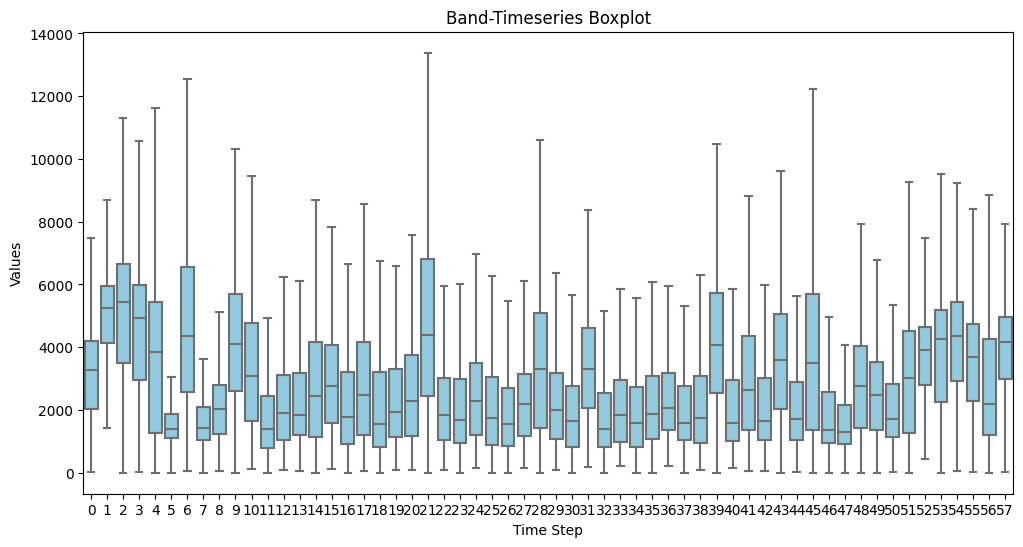

In [ ]:
# Reshape the data
reshaped_series = np.moveaxis(series, 1, -1).reshape(-1, series.shape[1])

# Create the box plot using Matplotlib
plt.figure(figsize=(12, 6))
sns.boxplot(reshaped_series, showfliers=False,
            color = 'skyblue')
plt.title('Band-Timeseries Boxplot')
plt.xlabel('Time Step')
plt.ylabel('Values')


plt.show()

#### Figure 0

The figure above is the boxplot for all bands through the whole timeseries. It is visible some trends of higher-lower values. This is probably related to the differences in the crops. For example, periods of higher reflectance during winter due to the snow, or harvest time.



Now, in order to inspect the labels distribution, a `value_counts` is done. This allows the identification of erros in the dataset, whether there are extra-labels or not.

In [ ]:
#Checking The Count of Labels
pd.Series(labels).value_counts().reset_index(name = 'Count').sort_values(by='index')

,index,Count
1,0,10135
9,1,460
0,2,18231
10,3,288
7,4,588
12,5,65
15,6,5
16,7,3
14,8,20
11,9,85


In [ ]:
#Checking if labels shape is the same as the Series
labels.shape[0] == series.shape[0]

#if true, means that there is a problem with indexing because our class_names'
# last index is 16, and above it 18 (skipping 13 and 14)

In [ ]:
# Display the class_names

print("Class Names:")
print(class_names)
print('Length: ', len(class_names))

Class Names:
['corn' 'horsebeans' 'meadow' 'spring_barley' 'spring_oat' 'spring_peas'
 'spring_rapeseed' 'spring_rye' 'spring_triticale' 'spring_wheat'
 'sunflowers' 'unknown' 'winter_barley' 'winter_rapeseed' 'winter_rye'
 'winter_triticale' 'winter_wheat']
Length:  17


In [ ]:
#-- Mapping dictionary

label_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10,
                 11: 11, 12: 12, 15: 13, 16: 14, 17: 15, 18: 16}

# Remap labels using the mapping dictionary
remap_labels = [label_mapping[label] for label in labels]
remap_labels = np.array(remap_labels)

**Mapping dictionary**

Since we have a gap in the indexing and the amount of labels and classes are the same (17), we are adjusting the indexes from `labels` to match the indexes in the `class_names`.

In [ ]:
class_counts = pd.Series(remap_labels).value_counts().reset_index(name='Count')
class_counts = class_counts.sort_values(by='index').reset_index(drop=True)
class_counts['Class'] = class_counts['index'].map(lambda idx: class_names[idx])

class_counts

,index,Count,Class
0,0,10135,corn
1,1,460,horsebeans
2,2,18231,meadow
3,3,288,spring_barley
4,4,588,spring_oat
5,5,65,spring_peas
6,6,5,spring_rapeseed
7,7,3,spring_rye
8,8,20,spring_triticale
9,9,85,spring_wheat


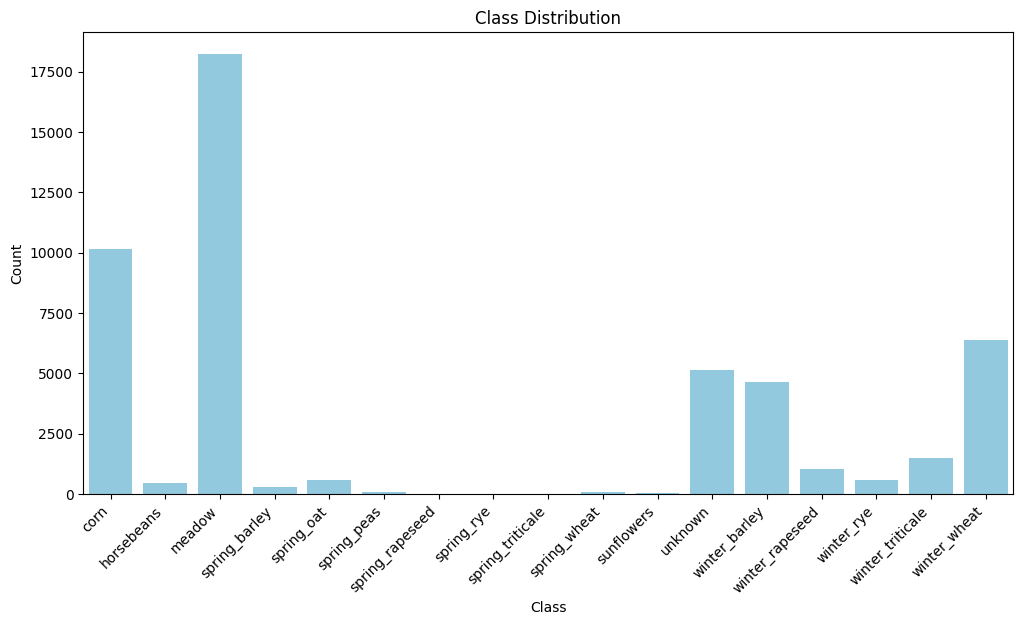

In [ ]:
# Create a histogram to visualize the class distribution

plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', data=class_counts, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

#### Figure 1
The chart above shows the distribution of each class. It is visible that the most common samples is `meadow` with almost twice the number of samples from `corn`. The others samples that are relevant in amount of samples are: `winter wheat`, `unknown` and `winter barley`.

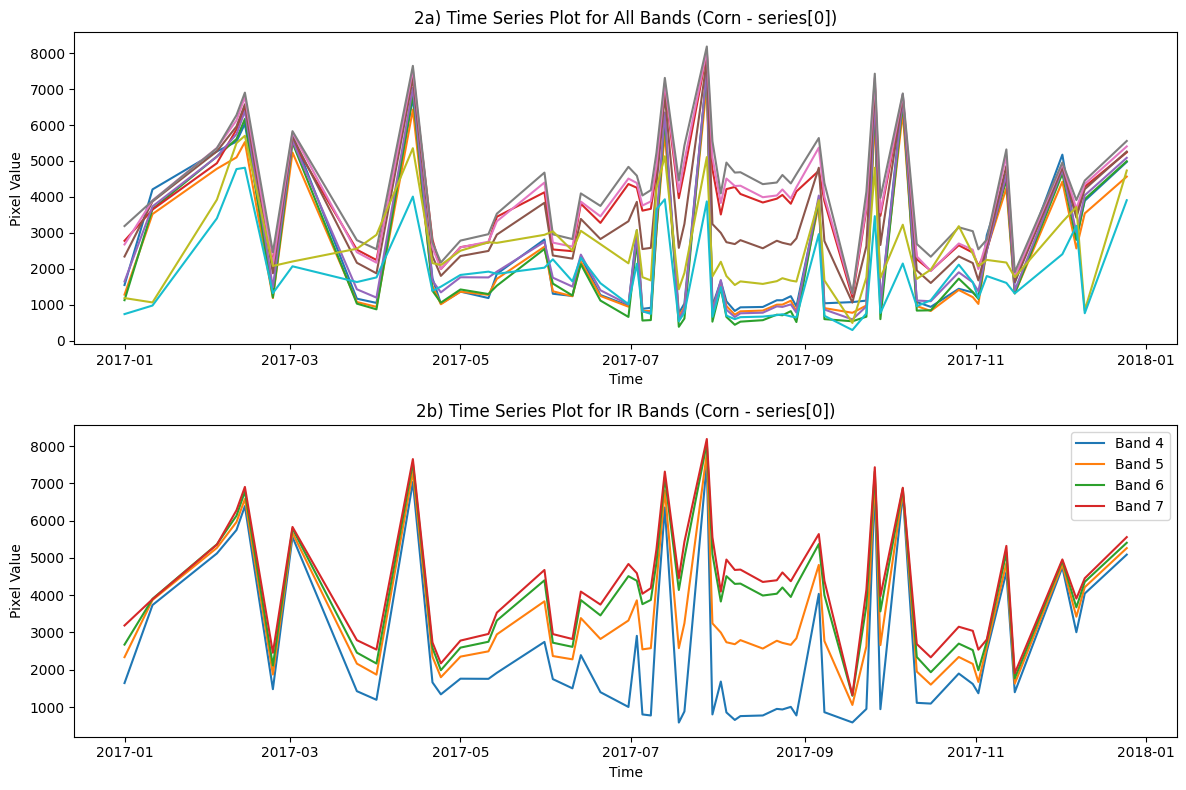

In [ ]:
plt.figure(figsize=(12, 8))

# Extract time series for the label "corn"
corn_label_index = np.where(class_names == 'corn')[0][0]
corn_time_series = series[labels == corn_label_index]

# Subplot 1 - All Bands
plt.subplot(2, 1, 1)
plt.plot(dates, corn_time_series[0])
plt.title('2a) Time Series Plot for All Bands (Corn - series[0])')
plt.xlabel('Time')
plt.ylabel('Pixel Value')

# Subplot 2 - Infrared Bands
plt.subplot(2, 1, 2)
plt.plot(dates, corn_time_series[0, :, 4:8])
plt.title('2b) Time Series Plot for IR Bands (Corn - series[0])')
plt.xlabel('Time')
plt.ylabel('Pixel Value')
plt.legend(['Band 4', 'Band 5', 'Band 6', 'Band 7'])

plt.tight_layout()
plt.show()

#### Figure 2
Above it is plotted the time series for corn crop. Each line represents a different band. X-axis represents the date and Y-axis the pixel value. From this chart, we can see there are periods of high spectral response, and other with low-to-medium response. Knowing that the colder period, where there is snow precipitation, is occurs from November until April. The high reflectance of bands might be related to snow or bare soil. April to May, the high reflectance might be to the preparation of the fields for the seeding. Largest peaks are in July-August, when you have a lot of absortion of IR bands by the growing crop. And finally, the peaks in September matches the harvesting period.

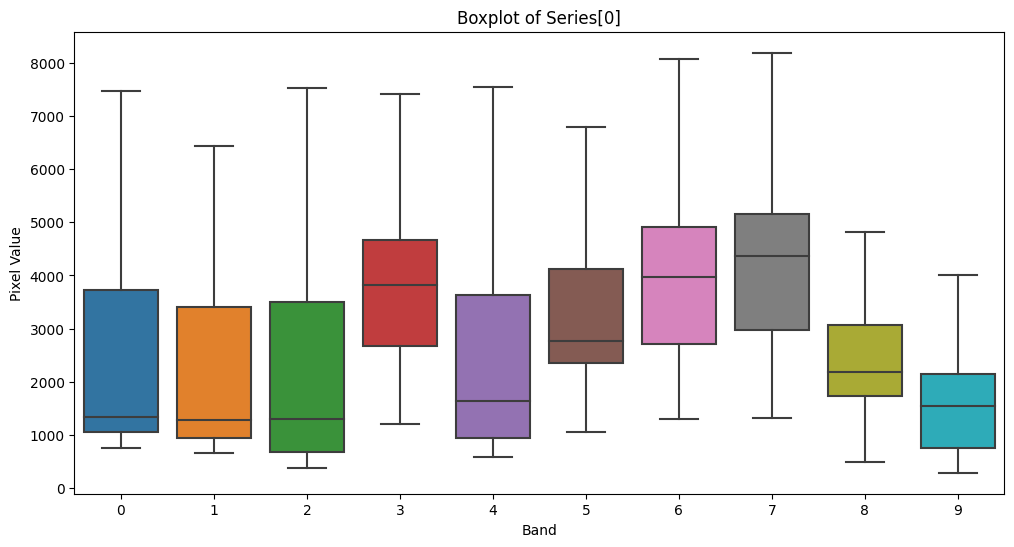

In [ ]:
# Plot a boxplot for series[0]
plt.figure(figsize=(12, 6))
sns.boxplot(data=series[0], showfliers=False)
plt.title('Boxplot of Series[0]')
plt.xlabel('Band')
plt.ylabel('Pixel Value')
plt.show()

#### Figure 3

The chart above shows the box plots of all 10 bands for `series[0]`. With this visualization it's possible to indentify which band is which based on their range of pixel values, also, how the values are spread.

In [ ]:
#-- Making a reshape to plot histograms distribuition for the bands
series_bands = series.reshape((m * l, d))

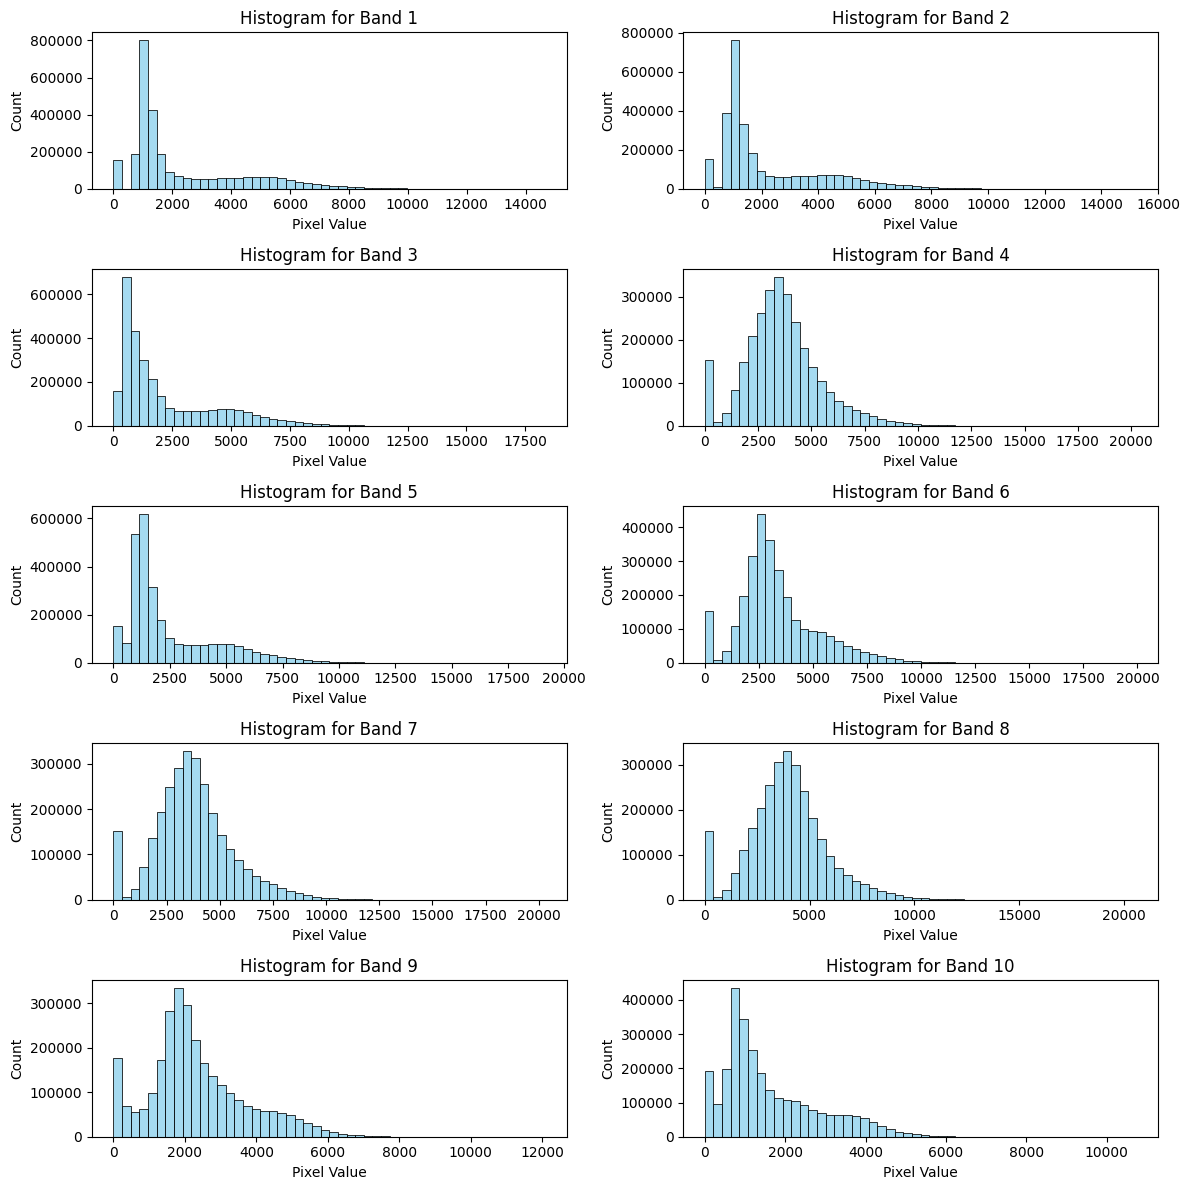

In [ ]:
# Get the number of bands
d = series_bands.shape[1]

# Define the number of rows and columns for subplots
num_rows = d // 2
num_cols = 2

# Create subplots
plt.figure(figsize=(12, 12))

for i in range(d):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(series_bands[:, i], kde=False, color='skyblue', bins=50)
    plt.title(f'Histogram for Band {i + 1}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### Figure 4

Overall, all bands are left-skewed. Some of them have a narrower values of pixels, such as bands 5 and 6. This information make sense due to the fact that these bands are in the NIR field, capturing a lot of vegetation information. Meanwhile, Bands 1 and 2  have the most spread-out histograms, indicating a wide range of pixel values. This could be due to variations in terrain and vegetation.

### Learning Task

After analyzing the whole dataset, it is possible to state that this project involves a Supervised Learning task focused on conducting timeseries pixel classifications.

## 2. Workflow Preparation

In [ ]:
#@title 2.1) Dataset Class definition
from torch.utils.data import Dataset

class MLPDataset(Dataset):
    def __init__(self, data, labels):
        """
        Args:
            data (numpy.ndarray): Input data of shape [samples, bands, time].
            labels (numpy.ndarray): Vector containing labels for each sample.
        """
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index].reshape(-1)
        label = self.labels[index]
        return sample, label

class NNDataset(Dataset):
    def __init__(self, data, labels):
        """
        Args:
            data (numpy.ndarray): Input data of shape [samples, bands, time].
            labels (numpy.ndarray): Vector containing labels for each sample.
        """
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]
        # Add NN-specific data shaping if needed
        return sample, label


### 2.2) Data Split & Normalization

In order to train the models, data will be splitted in 80% train, 10% test and 10% validation.

Following data split, all band values will be normalized, since they have different ranges. Not normalizing would lead to the instability of the model.

In [ ]:
#-- Setting X and Y classes
X = series
Y = remap_labels

#-- Number of classes
num_classes = len(class_names)

In [ ]:
# Split the data indices based on remap_labels
# Split the data into 80-10-10
indices = torch.arange(len(Y))
indices_train, indices_temp = train_test_split(indices, test_size=0.25, random_state=42, stratify=Y)
indices_test, indices_val = train_test_split(indices_temp, test_size=0.5, random_state=42, stratify=None)

**Disclamer**:

In the second data-split, there was no stratification due to the issue regarding some classes where there was only one values, making it impossible to stratify, since it requires at least 2 values.

In [ ]:
# Split the data using the obtained indices
X_train_temp, X_test, Y_train_temp, Y_test = X[indices_train], X[indices_test], Y[indices_train], Y[indices_test]
X_val, Y_val = X[indices_val], Y[indices_val]

# Normalize the data after splitting
# Now that the dataset is split, the normalization can be done.
# Doing normalization at this step is crucial to avoid any data leakage.
X_train_normalized = (X_train_temp - np.mean(X_train_temp)) / np.std(X_train_temp, ddof=1)
X_val_normalized = (X_val - np.mean(X_val)) / np.std(X_val, ddof=1)
X_test_normalized = (X_test - np.mean(X_train_temp)) / np.std(X_train_temp, ddof=1)


# Check the shapes of the resulting sets
print("X_train shape:", X_train_temp.shape)
print("Y_train shape:", Y_train_temp.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)



X_train shape: (36876, 58, 10)
Y_train shape: (36876,)
X_test shape: (6146, 58, 10)
Y_test shape: (6146,)
X_val shape: (6146, 58, 10)
Y_val shape: (6146,)


In [ ]:
# Train Set
X_train_tensor = torch.LongTensor(X_train_normalized)
Y_train_tensor = torch.LongTensor(Y_train_temp)

# Test Set
X_test_tensor = torch.LongTensor(X_test_normalized)
Y_test_tensor = torch.LongTensor(Y_test)

# Validation Set
X_val_tensor = torch.LongTensor(X_val_normalized)
Y_val_tensor = torch.LongTensor(Y_val)

Below, the GPU will be activated and the data will be added to it, in order to use the processing power from it.

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train Set
X_train_tensor = X_train_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)

# Test Set
X_test_tensor = X_test_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)

# Validation Set
X_val_tensor = X_val_tensor.to(device)
Y_val_tensor = Y_val_tensor.to(device)


In [ ]:
mlp_train = MLPDataset(X_train_tensor, Y_train_tensor)
mlp_val = MLPDataset(X_val_tensor, Y_val_tensor)
mlp_test = MLPDataset(X_test_tensor, Y_test_tensor)

vanilla_train = NNDataset(X_train_tensor, Y_train_tensor)
vanilla_val = NNDataset(X_val_tensor, Y_val_tensor)
vanilla_test =  NNDataset(X_test_tensor, Y_test_tensor)


In [ ]:
# Create DataLoader instances for training, validation, and test sets
batch_size = 32

#MLP
train_loader = DataLoader(dataset=mlp_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=mlp_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=mlp_test, batch_size=batch_size, shuffle=True)

#Vanilla
vanilla_train_loader = DataLoader(dataset=vanilla_train, batch_size=batch_size, shuffle=True)
vanilla_val_loader = DataLoader(dataset=vanilla_val, batch_size=batch_size, shuffle=True)
vanilla_test_loader = DataLoader(dataset=vanilla_test, batch_size=batch_size, shuffle=True)

## 3. Multi-Layer Perceptron

### 3.1) The MLP Structure

The Multi Perceptron Layer below has an amount of 4 layers, with 17 outputs, representing exactly the total number of classes.

The `input size` is **580**, the result of a 3D to 2D operation, represented by the 58 dates and 10 bands.

The amount of `hidden units` was defined by 2/3 of the total amount of the `input size` then summing with the number of classes, achieving the value of 404.[[2]](https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3)

For the `activation function`, ReLu was chosen. Specially because for the optimization, SGD is also being used, which simulates a linear function even though it isn't one, helping the model to understand complex structures in the data [[3]](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/).

In [ ]:
class MultiPerceptronLayer(nn.Module):
    def __init__(self, in_size, hidden_units, out_size):
        super(MultiPerceptronLayer, self).__init__()

        # Let us now define the linear layers we need:
        self.fc1 = nn.Linear(in_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, hidden_units)
        self.fc4 = nn.Linear(hidden_units,out_size)

    # We have also to define what is the forward of this module:
    def forward(self, x):
        h1 = nn.functional.relu(self.fc1(x))
        h2 = nn.functional.relu(self.fc2(h1))
        h3 = nn.functional.relu(self.fc3(h2))
        logits = self.fc4(h3)
        return logits

**Loss Function**

Since this project deals with multi-class classification, the best loss function to this kind of issue is the `Cross Entropy Loss` [[4]](https://www.analyticsvidhya.com/blog/2022/06/understanding-loss-function-in-deep-learning/#h-b-classification-loss)

In [ ]:
# Loss function
def loss_func(y_hat, y):
    return nn.CrossEntropyLoss()(y_hat, y)

In [ ]:
#@title Train & Plot Function
def train_and_plot(model, train_loader, val_loader, loss_func, optimizer, device, epochs):
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    model.to(device)

    for e in range(epochs):
        # Training
        model.train()
        train_correct = 0
        for x_train_batch, y_train_batch in train_loader:
            x_train_batch = x_train_batch.to(device)
            y_train_batch = y_train_batch.to(device)

            y_hat = model(x_train_batch)  # Forward pass

            loss = loss_func(y_hat, y_train_batch)  # Compute the loss
            loss.backward()  # Obtain the gradients with respect to the loss
            optimizer.step()  # Perform one step of gradient descent
            optimizer.zero_grad()  # Reset the gradients to 0

            y_hat_class = torch.argmax(y_hat.detach().cpu(), axis=1)
            train_correct += torch.sum(y_hat_class == y_train_batch.cpu())
            train_loss.append(loss.item() / len(x_train_batch))

        train_accuracy.append(train_correct / len(train_loader.dataset))

        # Validation
        model.eval()
        tmp_val_loss = 0
        val_correct = 0

        with torch.no_grad():
            for x_val_batch, y_val_batch in val_loader:
                x_val_batch = x_val_batch.to(device)
                y_val_batch = y_val_batch.to(device)

                y_val_hat = model(x_val_batch)  # Forward pass
                tmp_val_loss += loss_func(y_val_hat, y_val_batch).item()

                y_val_hat_class = torch.argmax(y_val_hat.detach().cpu(), axis=1)
                val_correct += torch.sum(y_val_hat_class == y_val_batch.cpu())

        val_loss.append(tmp_val_loss / len(val_loader.dataset))
        val_accuracy.append(val_correct / len(val_loader.dataset))

        # Plotting
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(train_loss, label='Train Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracy, label='Train Accuracy')
        plt.plot(val_accuracy, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()




In [ ]:
print(f'Total number of Classes: {num_classes}')

num_features = (X.shape[1]*X.shape[2])
print(f'Number of features: {num_features}')

hidden_units = math.ceil((2/3*num_features + num_classes))
print(f'Hidden Units Value: {hidden_units}')

Total number of Classes: 17
Number of features: 580
Hidden Units Value: 404


In [ ]:
model_MLP = MultiPerceptronLayer(in_size = num_features, hidden_units = hidden_units, out_size = num_classes)

optimizer = optim.SGD(model_MLP.parameters(), lr=.01, momentum = 0.9)

In [ ]:
model_MLP

MultiPerceptronLayer(
  (fc1): Linear(in_features=580, out_features=404, bias=True)
  (fc2): Linear(in_features=404, out_features=404, bias=True)
  (fc3): Linear(in_features=404, out_features=404, bias=True)
  (fc4): Linear(in_features=404, out_features=17, bias=True)
)

In [ ]:
#@title Train, Test & Validation Functions
def train_model(model, train_loader, loss_func, optimizer, device):
    model.train()
    train_correct = 0
    train_loss = 0

    for x_train_batch, y_train_batch in train_loader:
        x_train_batch = x_train_batch.to(device).float()
        y_train_batch = y_train_batch.to(device).long()

        y_hat = model(x_train_batch)  # Forward pass

        loss = loss_func(y_hat, y_train_batch)  # Compute the loss
        loss.backward()  # Obtain the gradients with respect to the loss
        optimizer.step()  # Perform one step of gradient descent
        optimizer.zero_grad()  # Reset the gradients to 0

        y_hat_class = torch.argmax(y_hat.detach().cpu(), axis=1)
        train_correct += torch.sum(y_hat_class == y_train_batch.cpu())
        train_loss += loss.item()

    accuracy = train_correct / len(train_loader.dataset)
    average_loss = train_loss / len(train_loader.dataset)

    return average_loss, accuracy

def validate_model(model, val_loader, loss_func, device):
    model.eval()
    val_correct = 0
    val_loss = 0

    with torch.no_grad():
        for x_val_batch, y_val_batch in val_loader:
            x_val_batch = x_val_batch.to(device).float()
            y_val_batch = y_val_batch.to(device).long()

            y_val_hat = model(x_val_batch)  # Forward pass
            val_loss += loss_func(y_val_hat, y_val_batch).item()

            y_val_hat_class = torch.argmax(y_val_hat.detach().cpu(), axis=1)
            val_correct += torch.sum(y_val_hat_class == y_val_batch.cpu())

    accuracy = val_correct / len(val_loader.dataset)
    average_loss = val_loss / len(val_loader.dataset)

    return average_loss, accuracy



def test_model(model, test_loader, loss_func, device):
    model.eval()
    test_correct = 0
    test_loss = 0

    with torch.no_grad():
        for x_test_batch, y_test_batch in test_loader:
            x_test_batch = x_test_batch.to(device).float()
            y_test_batch = y_test_batch.to(device).long()

            y_test_hat = model(x_test_batch)  # Forward pass
            test_loss += loss_func(y_test_hat, y_test_batch).item()

            y_test_hat_class = torch.argmax(y_test_hat.detach().cpu(), axis=1)
            test_correct += torch.sum(y_test_hat_class == y_test_batch.cpu())

    accuracy = test_correct / len(test_loader.dataset)
    average_loss = test_loss / len(test_loader.dataset)

    return average_loss, accuracy


def plot_results(train_loss, val_loss, train_accuracy, val_accuracy):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


### 3.1) Hyperparameter tunning

For tunning the model, there are two main variables that need to be set: `learning rate` and `momentum`, regarding the optimization function, which is the Stochastic Gradient Descendant.

By default, it is recommended to use `momentum` = **0.9** [[5]](https://distill.pub/2017/momentum/), [[6]](https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/), but it can (and should) be tunned.

Another important variable to be tunned is the `weight_decay`, since it works as a regularization function (Ridge Regularization - L2). However, trying to tune it would add a lot of complexity to the model, making it extremely expensive in terms of computational power and time.

Taking into consideration that it's recommended to test it from `0` to `0.1` [[7]](https://wiki.cloudfactory.com/docs/mp-wiki/solvers-optimizers/weight-decay), and adding more values to tune would increase processing time, the `weight_decay` was arbitrary set to `0.01`


Grid Search - Current Hyperparameters:
Learning Rate: 0.001
Momentum: 0.8
Best Validation Loss (Epoch 20): 0.01
Best Validation Accuracy (Epoch 20): 0.88


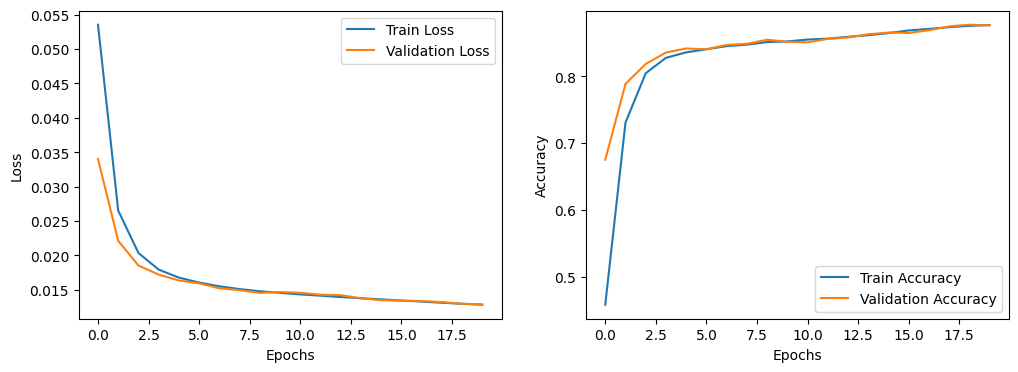


Grid Search - Current Hyperparameters:
Learning Rate: 0.001
Momentum: 0.9
Best Validation Loss (Epoch 19): 0.01
Best Validation Accuracy (Epoch 19): 0.88


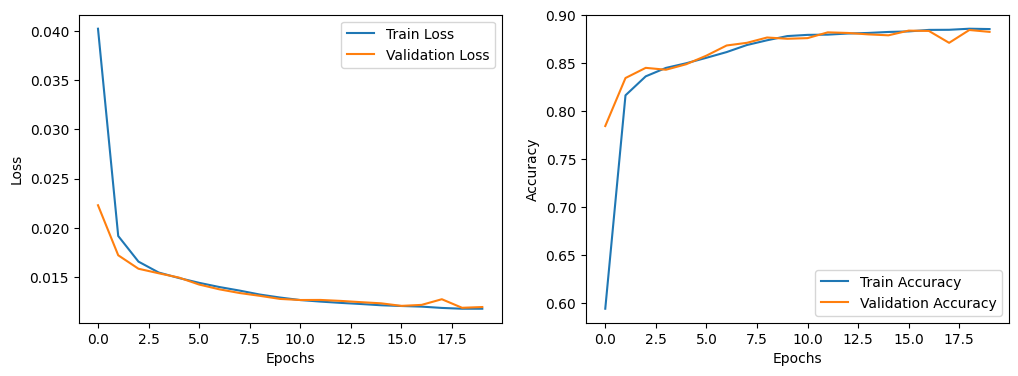


Grid Search - Current Hyperparameters:
Learning Rate: 0.01
Momentum: 0.8
Best Validation Loss (Epoch 14): 0.01
Best Validation Accuracy (Epoch 14): 0.89


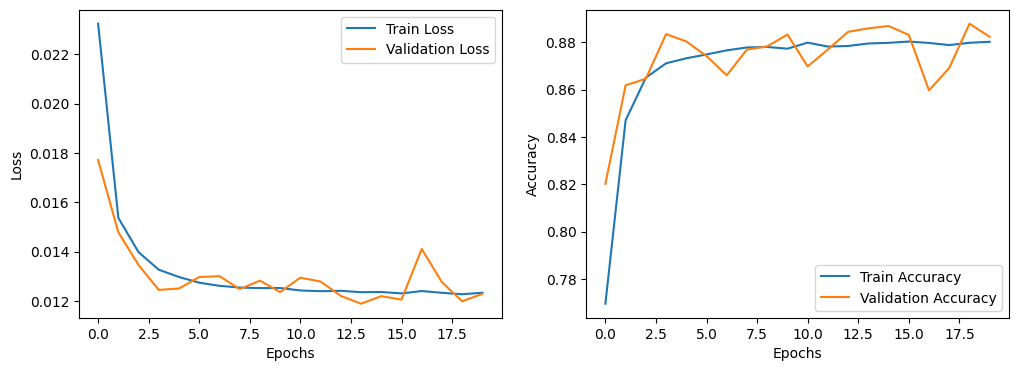


Grid Search - Current Hyperparameters:
Learning Rate: 0.01
Momentum: 0.9
Best Validation Loss (Epoch 15): 0.01
Best Validation Accuracy (Epoch 15): 0.88


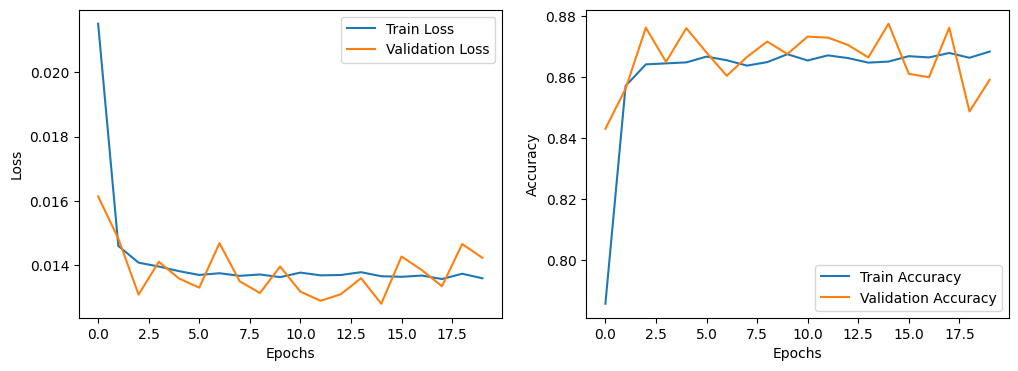


Grid Search - Current Hyperparameters:
Learning Rate: 0.1
Momentum: 0.8
Best Validation Loss (Epoch 19): 0.02
Best Validation Accuracy (Epoch 19): 0.82


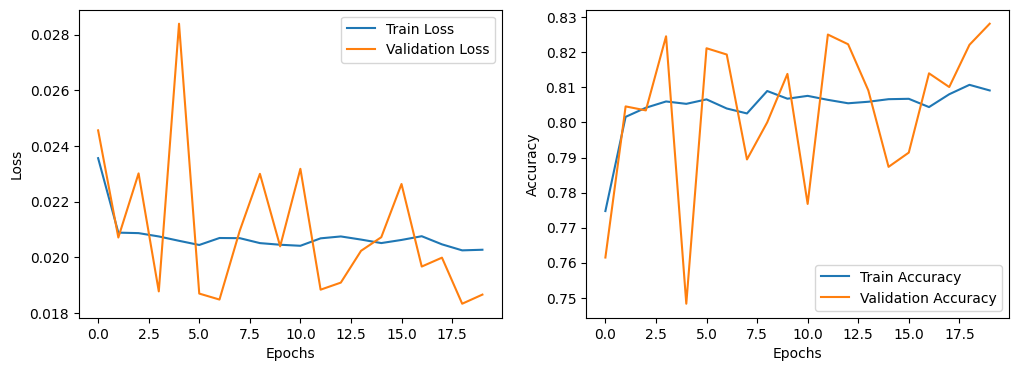


Grid Search - Current Hyperparameters:
Learning Rate: 0.1
Momentum: 0.9
Best Validation Loss (Epoch 1): 0.02
Best Validation Accuracy (Epoch 1): 0.79


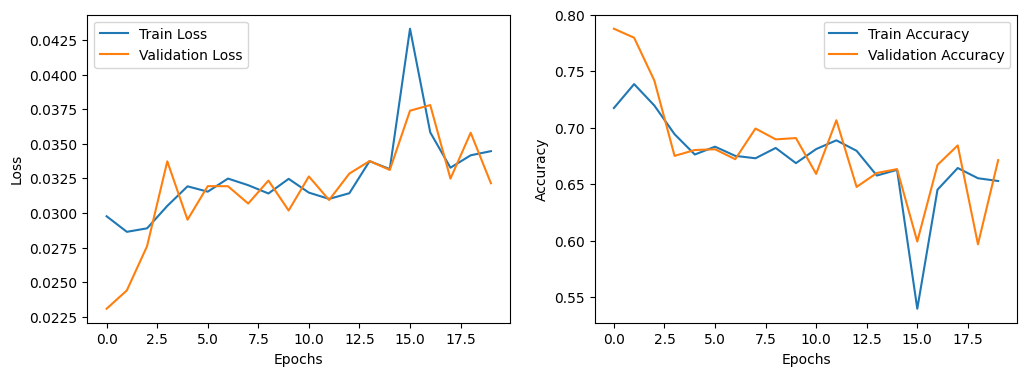

In [ ]:
# -- Setting the epochs
epochs = 20

# -- Grid search hyperparameter space
search_params = {
    'learning_rate': [0.001, 0.01, 0.1],
    'momentum': [0.8, 0.9]
}

gridSearch = ParameterGrid(search_params)

# Initialize variables to track the best model and its performance
best_val_loss = float('inf')
best_val_acc = 0
best_hyperparameters = {}

# -- Grid search loop
for parameter in gridSearch:
    lr = parameter['learning_rate']
    momentum = parameter['momentum']

    print(f"\nGrid Search - Current Hyperparameters:")
    print(f"Learning Rate: {lr}")
    print(f"Momentum: {momentum}")

    # -- Setting up the model
    model_MLP_tuning = MultiPerceptronLayer(in_size=num_features,
                                            hidden_units=hidden_units,
                                            out_size=num_classes)
    model_MLP_tuning.to(device)

    optimizer_hyper = optim.SGD(model_MLP_tuning.parameters(),
                                lr=lr,
                                momentum=momentum,
                                weight_decay=0.01)

    # -- Training loop
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    for e in range(epochs):
        avg_train_loss, train_acc = train_model(model_MLP_tuning,
                                               train_loader,
                                               loss_func,
                                               optimizer_hyper,
                                               device)

        avg_val_loss, val_acc = validate_model(model_MLP_tuning,
                                              val_loader,
                                              loss_func,
                                              device)

        train_loss.append(avg_train_loss)
        train_accuracy.append(train_acc)
        val_loss.append(avg_val_loss)
        val_accuracy.append(val_acc)

    # -- Print best validation metrics after training
    best_epoch = val_loss.index(min(val_loss)) + 1
    best_val_loss = min(val_loss)
    best_val_acc = val_accuracy[best_epoch - 1]
    print(f"Best Validation Loss (Epoch {best_epoch}): {best_val_loss:.2f}")
    print(f"Best Validation Accuracy (Epoch {best_epoch}): {best_val_acc:.2f}")


    # Save model with hyperparameters in the filename
    model_filename = f'model_mlp_hyper_lr_{lr}_momentum_{momentum}.pth'
    torch.save(model_MLP_tuning.state_dict(), model_filename)

    # -- Plotting results using the provided function
    plot_results(train_loss, val_loss, train_accuracy, val_accuracy)


**Best Hyperparameters:**

`Learning Rate`: 0.001

`Momentum`: 0.8



## 4. Vanilla Recurrent Neural Network

The chosen Recurrent Neural Network to compare with the MLP is the simple Vanilla RNN.

RNNs are interesting because they can store a lot of previous information in an efficient way and share the weights. It is very useful for timeseries analysis, language modeling and speech recognition
[[8]](https://www.cs.toronto.edu/~tingwuwang/rnn_tutorial.pdf),[[9]](https://calvinfeng.gitbook.io/machine-learning-notebook/supervised-learning/recurrent-neural-network/recurrent_neural_networks).

In [ ]:
#@title Defining VanillaRNN Class
class VanillaRNN(nn.Module):
    def __init__(self, in_size, hidden_units, output_size, rec_layers, sequence_length):
        super(VanillaRNN, self).__init__()

        self.rnn = nn.RNN(input_size=in_size,
                          hidden_size=hidden_units,
                          num_layers=rec_layers,
                          batch_first=True)

        self.fc = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        # Assuming x has shape (batch_size, sequence_length, input_size)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

In [ ]:
#-- Setting the variables again to avoid scrolling up to check them again.

print(f'Total number of Classes: {num_classes}')

num_features = (X.shape[1]*X.shape[2])
print(f'Number of features: {num_features}')

hidden_units = math.ceil((2/3*num_features + num_classes))
print(f'Hidden Units Value: {hidden_units}')

rec_layers = 1
print(f'Number of Recurrent Layers: {rec_layers}')

date_len = 58
print(f'Number of datetime series: {date_len}')

band_len = 10
print(f'Number of bands available: {band_len}')

Total number of Classes: 17
Number of features: 580
Hidden Units Value: 404
Number of Recurrent Layers: 1
Number of datetime series: 58
Number of bands available: 10


### 4.1) Training & Tunning Vanilla Model



Ideally, the hyperparameter tunning would be in a for loop where we compare the results. However, since the model is taking almost 60 min to run 20 epochs, 5 models will be run in the row simulating this hyperparameter tunning. This helps in case of Google Colab disconnected, saving the previous results. Since it is expensive computationally and time-consuming, all models will be saved just to avoid the re-run.

It is going to be used the same approach as the one in the `3.4) Hyperparameter Tunning` for MLP. Both learning rate and momentum will be tunned.

##### Hyperparameter 01

- **LR** : 0.001
- **momentum** : 0.9

VanillaRNN(
  (rnn): RNN(10, 404, batch_first=True)
  (fc): Linear(in_features=404, out_features=17, bias=True)
)
Epoch 1/20
Train Loss: 0.05, Train Accuracy: 0.44
Validation Loss: 0.05, Validation Accuracy: 0.47
Epoch 2/20
Train Loss: 0.05, Train Accuracy: 0.47
Validation Loss: 0.05, Validation Accuracy: 0.49
Epoch 3/20
Train Loss: 0.03, Train Accuracy: 0.63
Validation Loss: 0.03, Validation Accuracy: 0.73
Epoch 4/20
Train Loss: 0.03, Train Accuracy: 0.73
Validation Loss: 0.02, Validation Accuracy: 0.78
Epoch 5/20
Train Loss: 0.02, Train Accuracy: 0.77
Validation Loss: 0.02, Validation Accuracy: 0.80
Epoch 6/20
Train Loss: 0.02, Train Accuracy: 0.80
Validation Loss: 0.02, Validation Accuracy: 0.78
Epoch 7/20
Train Loss: 0.02, Train Accuracy: 0.80
Validation Loss: 0.02, Validation Accuracy: 0.78
Epoch 8/20
Train Loss: 0.02, Train Accuracy: 0.82
Validation Loss: 0.02, Validation Accuracy: 0.84
Epoch 9/20
Train Loss: 0.02, Train Accuracy: 0.83
Validation Loss: 0.02, Validation Accuracy: 

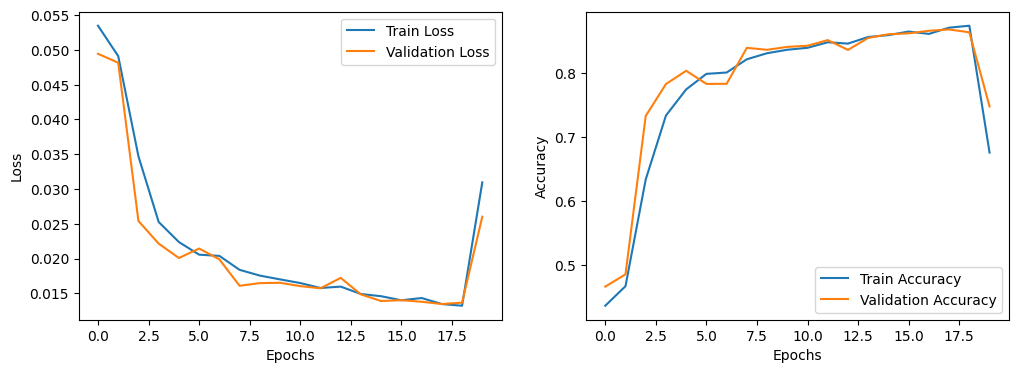

In [ ]:

#-- Setting the model
vanilla_model = VanillaRNN(in_size = band_len,
                           hidden_units = hidden_units,
                           output_size = num_classes,
                           rec_layers = rec_layers,
                           sequence_length = date_len)


optimizer = optim.SGD(vanilla_model.parameters(), lr=.001, momentum = 0.9)

# Print the model architecture
print(vanilla_model)

epochs = 20
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for e in range(epochs):
    avg_train_loss, train_acc = train_model(vanilla_model, vanilla_train_loader, loss_func, optimizer, device)
    avg_val_loss, val_acc = validate_model(vanilla_model, vanilla_val_loader, loss_func, device)

    train_loss.append(avg_train_loss)
    train_accuracy.append(train_acc)
    val_loss.append(avg_val_loss)
    val_accuracy.append(val_acc)

    print(f"Epoch {e + 1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.2f}, Train Accuracy: {train_acc:.2f}")
    print(f"Validation Loss: {avg_val_loss:.2f}, Validation Accuracy: {val_acc:.2f}")

# Plotting results
plot_results(train_loss, val_loss, train_accuracy, val_accuracy)

torch.save(vanilla_model.state_dict(), 'vanilla_model_tunning01.pth')


_____

##### Hyperparameter 02

- **LR** : 0.001
- **momentum** : 0.8

VanillaRNN(
  (rnn): RNN(10, 404, batch_first=True)
  (fc): Linear(in_features=404, out_features=17, bias=True)
)
Epoch 1/20
Train Loss: 0.06, Train Accuracy: 0.42
Validation Loss: 0.05, Validation Accuracy: 0.46
Epoch 2/20
Train Loss: 0.05, Train Accuracy: 0.46
Validation Loss: 0.05, Validation Accuracy: 0.47
Epoch 3/20
Train Loss: 0.05, Train Accuracy: 0.46
Validation Loss: 0.05, Validation Accuracy: 0.47
Epoch 4/20
Train Loss: 0.05, Train Accuracy: 0.47
Validation Loss: 0.05, Validation Accuracy: 0.48
Epoch 5/20
Train Loss: 0.04, Train Accuracy: 0.54
Validation Loss: 0.03, Validation Accuracy: 0.66
Epoch 6/20
Train Loss: 0.03, Train Accuracy: 0.71
Validation Loss: 0.02, Validation Accuracy: 0.75
Epoch 7/20
Train Loss: 0.02, Train Accuracy: 0.75
Validation Loss: 0.02, Validation Accuracy: 0.79
Epoch 8/20
Train Loss: 0.02, Train Accuracy: 0.78
Validation Loss: 0.02, Validation Accuracy: 0.81
Epoch 9/20
Train Loss: 0.02, Train Accuracy: 0.80
Validation Loss: 0.02, Validation Accuracy: 

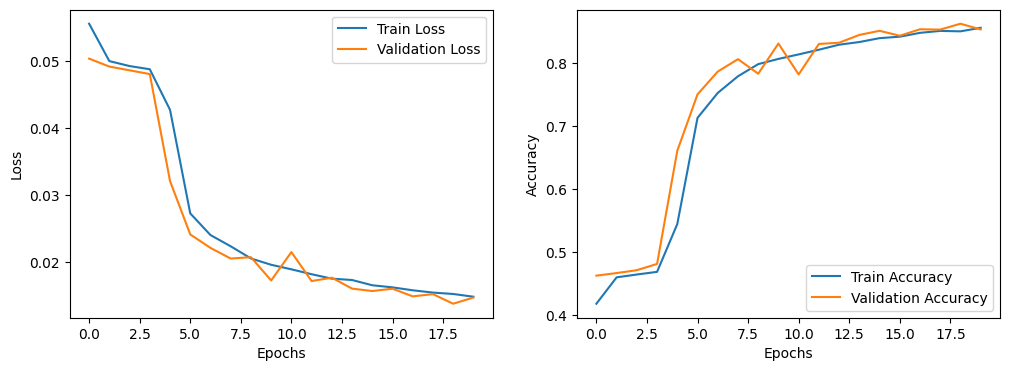

In [ ]:

#-- Setting the model
vanilla_model = VanillaRNN(in_size = band_len,
                           hidden_units = hidden_units,
                           output_size = num_classes,
                           rec_layers = rec_layers,
                           sequence_length = date_len)


optimizer = optim.SGD(vanilla_model.parameters(), lr=.001, momentum = 0.8)

# Print the model architecture
print(vanilla_model)

epochs = 20
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for e in range(epochs):
    avg_train_loss, train_acc = train_model(vanilla_model, vanilla_train_loader, loss_func, optimizer, device)
    avg_val_loss, val_acc = validate_model(vanilla_model, vanilla_val_loader, loss_func, device)

    train_loss.append(avg_train_loss)
    train_accuracy.append(train_acc)
    val_loss.append(avg_val_loss)
    val_accuracy.append(val_acc)

    print(f"Epoch {e + 1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.2f}, Train Accuracy: {train_acc:.2f}")
    print(f"Validation Loss: {avg_val_loss:.2f}, Validation Accuracy: {val_acc:.2f}")

# Plotting results
plot_results(train_loss, val_loss, train_accuracy, val_accuracy)

torch.save(vanilla_model.state_dict(), 'vanilla_model_tunning02.pth')


_____

##### Hyperparameter 03

- **LR** : 0.01
- **momentum** : 0.9

VanillaRNN(
  (rnn): RNN(10, 404, batch_first=True)
  (fc): Linear(in_features=404, out_features=17, bias=True)
)
Epoch 1/20
Train Loss: 0.05, Train Accuracy: 0.46
Validation Loss: 0.07, Validation Accuracy: 0.39
Epoch 2/20
Train Loss: 0.06, Train Accuracy: 0.39
Validation Loss: 0.06, Validation Accuracy: 0.42
Epoch 3/20
Train Loss: 0.06, Train Accuracy: 0.40
Validation Loss: 0.06, Validation Accuracy: 0.39
Epoch 4/20
Train Loss: 0.06, Train Accuracy: 0.41
Validation Loss: 0.07, Validation Accuracy: 0.35
Epoch 5/20
Train Loss: 0.06, Train Accuracy: 0.41
Validation Loss: 0.06, Validation Accuracy: 0.36
Epoch 6/20
Train Loss: 0.06, Train Accuracy: 0.40
Validation Loss: 0.06, Validation Accuracy: 0.45
Epoch 7/20
Train Loss: 0.06, Train Accuracy: 0.41
Validation Loss: 0.07, Validation Accuracy: 0.40
Epoch 8/20
Train Loss: 0.06, Train Accuracy: 0.41
Validation Loss: 0.06, Validation Accuracy: 0.43
Epoch 9/20
Train Loss: 0.06, Train Accuracy: 0.40
Validation Loss: 0.08, Validation Accuracy: 

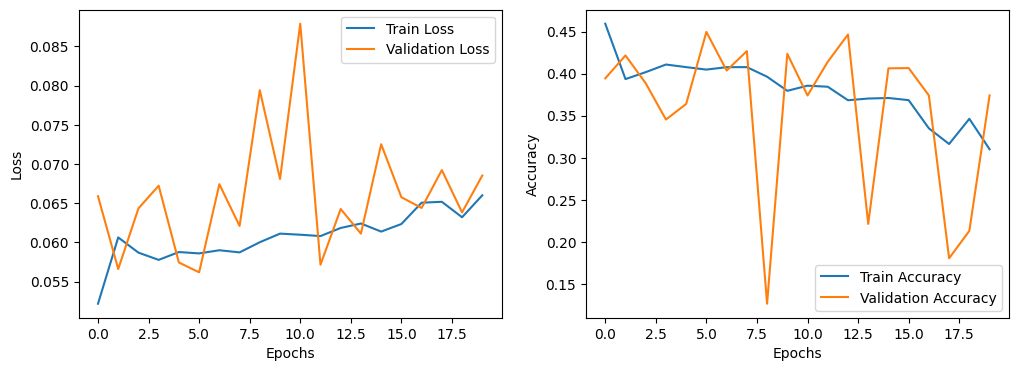

In [ ]:

#-- Setting the model
vanilla_model = VanillaRNN(in_size = band_len,
                           hidden_units = hidden_units,
                           output_size = num_classes,
                           rec_layers = rec_layers,
                           sequence_length = date_len)


optimizer = optim.SGD(vanilla_model.parameters(), lr=.01, momentum = 0.9)

# Print the model architecture
print(vanilla_model)

epochs = 20
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for e in range(epochs):
    avg_train_loss, train_acc = train_model(vanilla_model, vanilla_train_loader, loss_func, optimizer, device)
    avg_val_loss, val_acc = validate_model(vanilla_model, vanilla_val_loader, loss_func, device)

    train_loss.append(avg_train_loss)
    train_accuracy.append(train_acc)
    val_loss.append(avg_val_loss)
    val_accuracy.append(val_acc)

    print(f"Epoch {e + 1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.2f}, Train Accuracy: {train_acc:.2f}")
    print(f"Validation Loss: {avg_val_loss:.2f}, Validation Accuracy: {val_acc:.2f}")

# Plotting results
plot_results(train_loss, val_loss, train_accuracy, val_accuracy)

torch.save(vanilla_model.state_dict(), 'vanilla_model_tunning03.pth')


_____

##### Hyperparameter 04

- **LR** : 0.01
- **momentum** : 0.8

VanillaRNN(
  (rnn): RNN(10, 404, batch_first=True)
  (fc): Linear(in_features=404, out_features=17, bias=True)
)
Epoch 1/20
Train Loss: 0.05, Train Accuracy: 0.49
Validation Loss: 0.04, Validation Accuracy: 0.64
Epoch 2/20
Train Loss: 0.04, Train Accuracy: 0.58
Validation Loss: 0.03, Validation Accuracy: 0.64
Epoch 3/20
Train Loss: 0.03, Train Accuracy: 0.70
Validation Loss: 0.03, Validation Accuracy: 0.71
Epoch 4/20
Train Loss: 0.02, Train Accuracy: 0.78
Validation Loss: 0.02, Validation Accuracy: 0.83
Epoch 5/20
Train Loss: 0.02, Train Accuracy: 0.83
Validation Loss: 0.02, Validation Accuracy: 0.85
Epoch 6/20
Train Loss: 0.02, Train Accuracy: 0.85
Validation Loss: 0.01, Validation Accuracy: 0.85
Epoch 7/20
Train Loss: 0.01, Train Accuracy: 0.86
Validation Loss: 0.02, Validation Accuracy: 0.85
Epoch 8/20
Train Loss: 0.01, Train Accuracy: 0.86
Validation Loss: 0.01, Validation Accuracy: 0.87
Epoch 9/20
Train Loss: 0.01, Train Accuracy: 0.86
Validation Loss: 0.01, Validation Accuracy: 

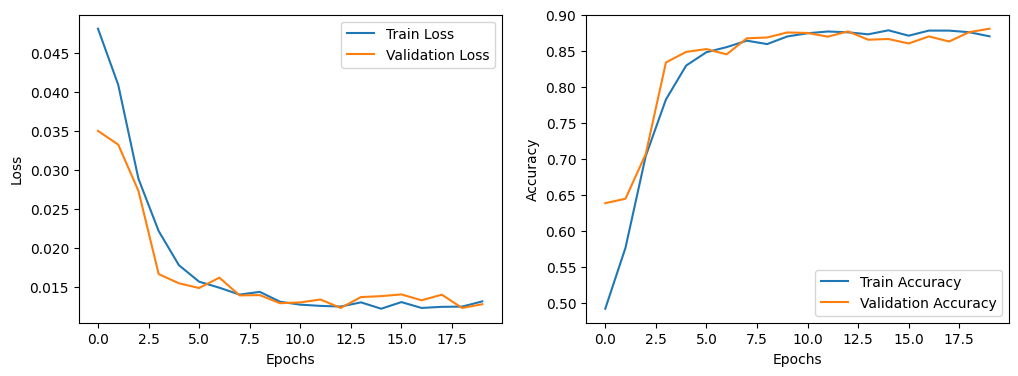

In [ ]:

#-- Setting the model
vanilla_model = VanillaRNN(in_size = band_len,
                           hidden_units = hidden_units,
                           output_size = num_classes,
                           rec_layers = rec_layers,
                           sequence_length = date_len)


optimizer = optim.SGD(vanilla_model.parameters(), lr=.01, momentum = 0.8)

# Print the model architecture
print(vanilla_model)

epochs = 20
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for e in range(epochs):
    avg_train_loss, train_acc = train_model(vanilla_model, vanilla_train_loader, loss_func, optimizer, device)
    avg_val_loss, val_acc = validate_model(vanilla_model, vanilla_val_loader, loss_func, device)

    train_loss.append(avg_train_loss)
    train_accuracy.append(train_acc)
    val_loss.append(avg_val_loss)
    val_accuracy.append(val_acc)

    print(f"Epoch {e + 1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.2f}, Train Accuracy: {train_acc:.2f}")
    print(f"Validation Loss: {avg_val_loss:.2f}, Validation Accuracy: {val_acc:.2f}")

# Plotting results
plot_results(train_loss, val_loss, train_accuracy, val_accuracy)

torch.save(vanilla_model.state_dict(), 'vanilla_model_tunning04.pth')


_____

##### Hyperparameter 05

- **LR** : 0.1
- **momentum** : 0.9

VanillaRNN(
  (rnn): RNN(10, 404, batch_first=True)
  (fc): Linear(in_features=404, out_features=17, bias=True)
)
Epoch 1/20
Train Loss: 0.98, Train Accuracy: 0.25
Validation Loss: 1.11, Validation Accuracy: 0.26
Epoch 2/20
Train Loss: 1.09, Train Accuracy: 0.24
Validation Loss: 0.82, Validation Accuracy: 0.21
Epoch 3/20
Train Loss: 1.02, Train Accuracy: 0.24
Validation Loss: 0.74, Validation Accuracy: 0.30
Epoch 4/20
Train Loss: 1.03, Train Accuracy: 0.24
Validation Loss: 0.91, Validation Accuracy: 0.16
Epoch 5/20
Train Loss: 1.05, Train Accuracy: 0.25
Validation Loss: 0.91, Validation Accuracy: 0.16
Epoch 6/20
Train Loss: 1.08, Train Accuracy: 0.24
Validation Loss: 1.95, Validation Accuracy: 0.37
Epoch 7/20
Train Loss: 1.16, Train Accuracy: 0.24
Validation Loss: 1.33, Validation Accuracy: 0.11
Epoch 8/20
Train Loss: 1.03, Train Accuracy: 0.24
Validation Loss: 0.94, Validation Accuracy: 0.37
Epoch 9/20
Train Loss: 1.08, Train Accuracy: 0.24
Validation Loss: 0.54, Validation Accuracy: 

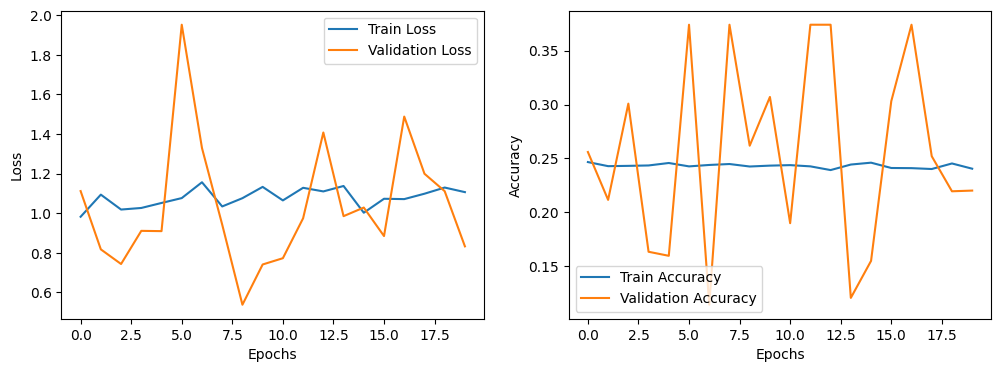

In [ ]:

#-- Setting the model
vanilla_model = VanillaRNN(in_size = band_len,
                           hidden_units = hidden_units,
                           output_size = num_classes,
                           rec_layers = rec_layers,
                           sequence_length = date_len)


optimizer = optim.SGD(vanilla_model.parameters(), lr=.1, momentum = 0.9)

# Print the model architecture
print(vanilla_model)

epochs = 20
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for e in range(epochs):
    avg_train_loss, train_acc = train_model(vanilla_model, vanilla_train_loader, loss_func, optimizer, device)
    avg_val_loss, val_acc = validate_model(vanilla_model, vanilla_val_loader, loss_func, device)

    train_loss.append(avg_train_loss)
    train_accuracy.append(train_acc)
    val_loss.append(avg_val_loss)
    val_accuracy.append(val_acc)

    print(f"Epoch {e + 1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.2f}, Train Accuracy: {train_acc:.2f}")
    print(f"Validation Loss: {avg_val_loss:.2f}, Validation Accuracy: {val_acc:.2f}")

# Plotting results
plot_results(train_loss, val_loss, train_accuracy, val_accuracy)

torch.save(vanilla_model.state_dict(), 'vanilla_model_tunning05.pth')


_____

##### Hyperparameter 06

- **LR** : 0.1
- **momentum** : 0.8

VanillaRNN(
  (rnn): RNN(10, 404, batch_first=True)
  (fc): Linear(in_features=404, out_features=17, bias=True)
)
Epoch 1/20
Train Loss: 0.94, Train Accuracy: 0.24
Validation Loss: 0.97, Validation Accuracy: 0.37
Epoch 2/20
Train Loss: 1.06, Train Accuracy: 0.22
Validation Loss: 1.26, Validation Accuracy: 0.37
Epoch 3/20
Train Loss: 1.03, Train Accuracy: 0.22
Validation Loss: 0.77, Validation Accuracy: 0.37
Epoch 4/20
Train Loss: 1.05, Train Accuracy: 0.22
Validation Loss: 0.66, Validation Accuracy: 0.37
Epoch 5/20
Train Loss: 1.03, Train Accuracy: 0.22
Validation Loss: 0.76, Validation Accuracy: 0.37
Epoch 6/20
Train Loss: 1.00, Train Accuracy: 0.23
Validation Loss: 0.77, Validation Accuracy: 0.03
Epoch 7/20
Train Loss: 1.03, Train Accuracy: 0.23
Validation Loss: 0.86, Validation Accuracy: 0.12
Epoch 8/20
Train Loss: 1.06, Train Accuracy: 0.23
Validation Loss: 0.93, Validation Accuracy: 0.37
Epoch 9/20
Train Loss: 1.04, Train Accuracy: 0.22
Validation Loss: 1.76, Validation Accuracy: 

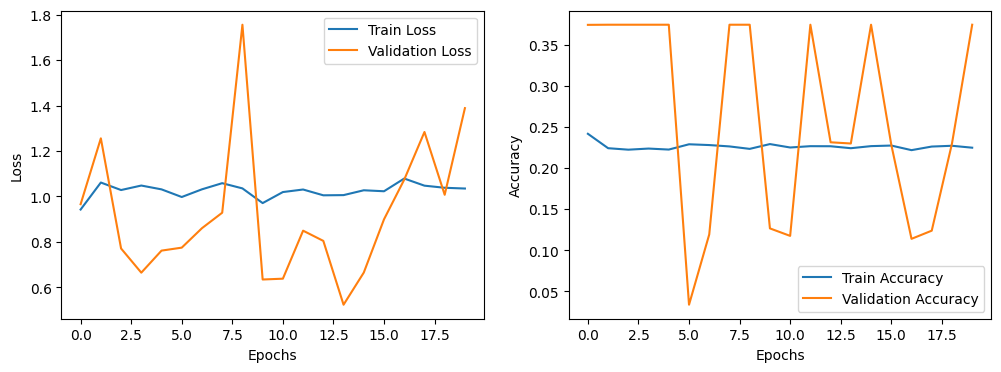

In [ ]:

#-- Setting the model
vanilla_model = VanillaRNN(in_size = band_len,
                           hidden_units = hidden_units,
                           output_size = num_classes,
                           rec_layers = rec_layers,
                           sequence_length = date_len)


optimizer = optim.SGD(vanilla_model.parameters(), lr=.1, momentum = 0.8)

# Print the model architecture
print(vanilla_model)

epochs = 20
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for e in range(epochs):
    avg_train_loss, train_acc = train_model(vanilla_model, vanilla_train_loader, loss_func, optimizer, device)
    avg_val_loss, val_acc = validate_model(vanilla_model, vanilla_val_loader, loss_func, device)

    train_loss.append(avg_train_loss)
    train_accuracy.append(train_acc)
    val_loss.append(avg_val_loss)
    val_accuracy.append(val_acc)

    print(f"Epoch {e + 1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.2f}, Train Accuracy: {train_acc:.2f}")
    print(f"Validation Loss: {avg_val_loss:.2f}, Validation Accuracy: {val_acc:.2f}")

# Plotting results
plot_results(train_loss, val_loss, train_accuracy, val_accuracy)

torch.save(vanilla_model.state_dict(), 'vanilla_model_tunning06.pth')


The best model from the hyperparameter tunning is the 4th, where

- `learning rate` = 0.01
- `momentum` = 0.8

Among all models, this seems to best generalize new data, being able to learn from it. An important point to highlight is that, due to the demanding task, the models ran only for 20 epochs. It would be interesting to have a couple more to have all assumptions 100% confirmed. For example, training loss converged well, but it's visible that it needs some more epochs to turn completly flat.

## 5. Performance Comparison

### 5.1) MLP Testing

In [ ]:
#loading the model
loaded_MLP_model = MultiPerceptronLayer(in_size=num_features,
                                        hidden_units=hidden_units,
                                        out_size=num_classes)

# Load the saved state dictionary
loaded_MLP_model.load_state_dict(torch.load('model_mlp_hyper_lr_0.001_momentum_0.8.pth'))


<All keys matched successfully>

In [ ]:
# Testing loop
test_loss, test_accuracy = test_model(loaded_MLP_model, test_loader, loss_func, device)

print(f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")


Test Loss: 0.01, Test Accuracy: 0.88


### 5.2) Vanilla RNN Testing

In [ ]:
#loading the model
loaded_RNN_model = VanillaRNN(in_size = band_len,
                           hidden_units = hidden_units,
                           output_size = num_classes,
                           rec_layers = rec_layers,
                           sequence_length = date_len)

# Load the saved state dictionary
loaded_RNN_model.load_state_dict(torch.load('vanilla_model_tunning04.pth'))


<All keys matched successfully>

In [ ]:
# Testing loop
test_loss, test_accuracy = test_model(loaded_RNN_model, vanilla_test_loader, loss_func, device)

print(f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")


Test Loss: 0.01, Test Accuracy: 0.88


## 6. Conclusions

Both models got very high accuracy at 88%.

- `Vanilla RNN accuracy`: 88%

- `MLP accuracy`: 88%

The MLP performed 1% better in the testing dataset than in the training part. Vanilla RNN got the same result.

Overall, since they have the same accuracy, it'd be preferable to pick the MLP because of less time consuming processing period.

Another thing to highlight is the amount of epochs. Very probably the models would perform better if it had more epochs to train, reaching full convergence in the training loss curve, and confirming the presence of overfitting based on the accuracies. Once again, it was limited due to the processing time.

From what is presented in the charts and the final model, it does not indicate overfitting, showing the importance of `weight_decay` for both models.

Extra data to test the models would be interesting to guarantee their ability to predict and that they are not overfitting.


### Extra references

- OpenAI. (2024). ChatGPT (November 21 version) [Large language model](https://chat.openai.com/chat)